# Parse all jsons into a the daily prices dataset

In [1]:
try:
    import mplfinance
except:
    ! pip install mplfinance
    import mplfinance
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from pprint import pprint
import logging
# set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# create a file handler
handler = logging.FileHandler('dataset_build.log')
handler.setLevel(logging.INFO)
# create a logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(handler)

Convert jsons into an easy to use dict

In [2]:
prices = {}
# iterate over all json files in the prices folder
for file in tqdm(os.listdir('prices')):
    # open the json file
    with open(os.path.join('prices', file)) as f:
        daily_stock = json.load(f)
        if 'Time Series (Daily)' not in daily_stock:
            logger.error('No time series data for {}'.format(file))
            continue
        prices[daily_stock['Meta Data']['2. Symbol']] = daily_stock['Time Series (Daily)']

100%|██████████| 17/17 [00:00<00:00, 217.96it/s]


<span style="color:red">TODO Later on extend the script to recapture stocks that the dataset_build log recorded as failures</span>

In [3]:
# create a row for each stock and date
rows = []
for stock, daily_prices in tqdm(prices.items()):
    for date, price in daily_prices.items():
        rows.append([stock, date, price['1. open'], price['2. high'], price['3. low'], price['4. close'], price['5. adjusted close'], price['6. volume'], price['7. dividend amount'], price['8. split coefficient']])
# create a dataframe from the rows
price_df = pd.DataFrame(rows, columns=['stock', 'date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'dividend', 'split'])
price_df['date'] = pd.to_datetime(price_df['date'])
# convert all columns to numeric except for the date and stock
price_df[price_df.columns[2:]] = price_df[price_df.columns[2:]].apply(pd.to_numeric, errors='coerce')

100%|██████████| 17/17 [00:00<00:00, 17152.55it/s]


### Merge the new price dataset with the existing dataset

In [4]:
old_price_df = pd.read_csv('daily_prices_7_2.csv')
old_price_df['date'] = pd.to_datetime(old_price_df['date'])
old_price_df[old_price_df.columns[2:]] = old_price_df[old_price_df.columns[2:]].apply(pd.to_numeric, errors='coerce')
new_price_df = pd.concat([old_price_df, price_df], ignore_index=True).drop_duplicates(ignore_index=True).dropna(subset=['stock']).sort_values(['stock', 'date'])
# save the dataframe to a csv file
new_price_df.to_csv('daily_prices.csv', index=False)

In [5]:
new_price_df

,stock,date,open,high,low,close,adj_close,volume,dividend,split
0,A,2022-09-13,136.32,137.41,133.440,133.54,133.118326,1586967,0.0,1.0
1,A,2022-09-14,133.80,135.36,132.095,133.25,132.829242,1577007,0.0,1.0
2,A,2022-09-15,133.81,135.51,132.655,133.16,132.739526,1446479,0.0,1.0
3,A,2022-09-16,132.12,132.13,128.280,129.89,129.479852,2300604,0.0,1.0
4,A,2022-09-19,128.79,130.79,128.360,130.72,130.307231,1059566,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
417605,ZZZ,2023-01-30,0.01,0.01,0.010,0.01,0.010000,0,0.0,1.0
417606,ZZZ,2023-01-31,0.01,0.01,0.010,0.01,0.010000,0,0.0,1.0
417607,ZZZ,2023-02-01,0.01,0.01,0.010,0.01,0.010000,0,0.0,1.0
417608,ZZZ,2023-02-02,0.01,0.01,0.010,0.01,0.010000,0,0.0,1.0


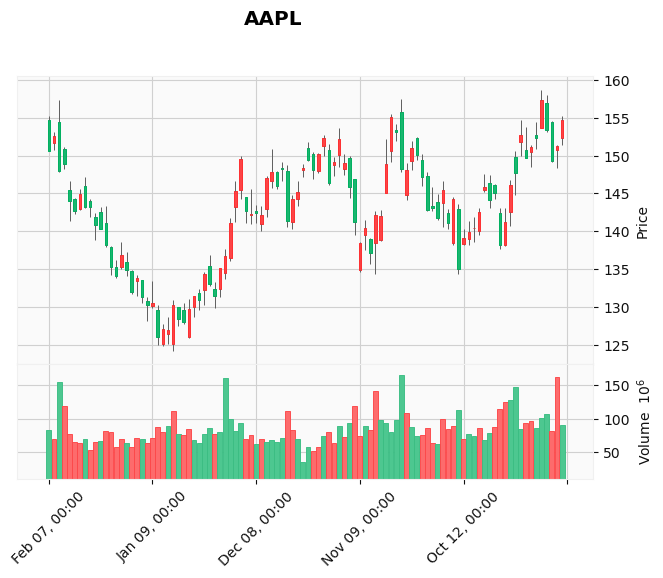

,stock,date,open,high,low,close,adj_close,volume,dividend,split
100,AMZN,2023-02-07,101.170,102.4100,98.080,102.11,102.11,119501301,0.0,1.0
101,AMZN,2023-02-06,102.925,103.9484,100.650,102.18,102.18,81945199,0.0,1.0
102,AMZN,2023-02-03,105.260,108.7800,102.520,103.39,103.39,144374828,0.0,1.0
103,AMZN,2023-02-02,110.245,114.0000,108.880,112.91,112.91,158154243,0.0,1.0
104,AMZN,2023-02-01,102.530,106.2400,101.240,105.15,105.15,80450121,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
195,AMZN,2022-09-21,122.490,123.7600,118.450,118.54,118.54,58498887,0.0,1.0
196,AMZN,2022-09-20,123.350,124.3963,121.140,122.19,122.19,47698432,0.0,1.0
197,AMZN,2022-09-19,122.160,124.7100,121.800,124.66,124.66,47279727,0.0,1.0
198,AMZN,2022-09-16,122.780,123.8700,120.700,123.53,123.53,115667804,0.0,1.0


In [6]:
# create a candlestick plot
mplfinance.plot(price_df[price_df['stock'] == 'AAPL'].set_index('date')[['open', 'high', 'low', 'close', 'volume']], type='candle', style='yahoo', volume=True, title='AAPL')
price_df[price_df['stock'] == 'AMZN']